# Escolaridad en México
##### Gabriel Missael Barco, 29/02/2020

En este mini-proyecto se analiza los datos encontrados en:
"Porcentaje de la población de 15 años y más con algún grado escolar por Entidad federativa, Nivel de escolaridad, Periodo y Sexo", Fuente: https://www.inegi.org.mx/app/tabulados/interactivos/default?px=Educacion_04&bd=Educacion, consultado el 28/02/2020 

Se contestan, mediante gráficas, las siguientes preguntas:

- ¿Existe relación entre la ubicación geografica y el porcentaje de personas sin escolaridad?
- ¿Existe relación entre la ubicación geografica y el porcentaje de personas que solo tienen educación básica?
- ¿Existe relación entre la ubicación geografica y el porcentaje de personas con educación media superior?
- ¿Existe relación entre la ubicación geografica y el porcentaje de personas con educación superior?
- ¿Hay diferencia entre el porcentaje de hombres y mujeres sin escolaridad en cada estado?
- ¿Hay diferencia entre el porcentaje de hombres y mujeres solo con eduación básica en cada estado?
- ¿Hay diferencia entre el porcentaje de hombres y mujeres con educación media superior en cada estado?
- ¿Hay diferencia entre el porcentaje de hombres y mujeres con educación superior en cada estado?
- ¿Cuantas personas hay en cada nivel de escolaridad en México?
- ¿Cuantas personas había en cada nivel de escolaridad en el año 2000?
- ¿Cuál ha sido el cambio de escolaridad en México a lo largo del tiempo?

In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

datos = pd.read_excel("../datos/escolaridad.xlsx")
poblacion = pd.read_excel("../datos/poblacion_2015.xlsx")
poblacion = poblacion.drop(0)

In [396]:
#Primeramente limpiamos y organizamos los datos

datos.columns = ["Entidad", "Escolaridad", 
                 "2000", "Hombres_2000", "Mujeres_2000",
                 "2005", "Hombres_2005", "Mujeres_2005",
                 "2010", "Hombres_2010", "Mujeres_2010",
                 "2015", "Hombres_2015", "Mujeres_2015"]
datos = datos.drop(0)

get = "jeje"
for i in range(198):
    if i%6 is 0:
        get = datos.iloc[i].Entidad
        if get == "Coahuila de Zaragoza":
            get = "Coahuila"
            datos.iloc[i].Entidad = get
        if get == "Veracruz de Ignacio de la Llave":
            get = "Veracruz"
            datos.iloc[i].Entidad = get
        if get == "Michoacán de Ocampo":
            get = "Michoacán"
            datos.iloc[i].Entidad = get
        if get == "Ciudad de México":
            get = "Distrito Federal"
            datos.iloc[i].Entidad = get
    else:
        datos.iloc[i].Entidad = get
        
datos2 = datos

In [397]:
def mexico(year, escolaridad, title, guardar):
    fig = plt.figure(figsize = (7,5))
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
    ax.set_extent([-114, -87, 13, 34], ccrs.Geodetic())


    shapename = 'admin_1_states_provinces'
    states_shp = shpreader.natural_earth(resolution='10m',
                                        category='cultural', name=shapename)

    cmap = mpl.cm.PRGn
    maximo = max(np.array(datos[datos.Escolaridad == escolaridad][year]))
    minimo = min(np.array(datos[datos.Escolaridad == escolaridad][year]))

    for state in shpreader.Reader(states_shp).records():
        if state.attributes["admin"] == "Mexico":
            nome = state.attributes['name']
            if nome in np.array(datos.Entidad):
                numero = float(datos[datos.Escolaridad == escolaridad][datos.Entidad == nome][year])
                ax.add_geometries(state.geometry, ccrs.PlateCarree(),
                                  facecolor=cmap(numero / float(maximo), 1),
                                  label=nome)
            else:
                ax.add_geometries(state.geometry, ccrs.PlateCarree(),
                                  facecolor='#FAFAFA',
                                  label=nome)

    ax.add_feature(cfeature.BORDERS, linestyle='solid')
    ax.add_feature(cfeature.COASTLINE, linestyle = "solid")
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', "10m",edgecolor='black', facecolor='none'), linestyle = "--")
    ax.add_feature(cfeature.LAND, facecolor = "gray")
    ax.add_feature(cfeature.OCEAN)
    ax.set_title(title)

    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap = "PRGn"), label = "Porcentaje de personas (%)", 
                         fraction = 0.046, pad = 0.04, )
    indices = np.int_(np.linspace(minimo, maximo, 6))
    cbar.ax.set_yticklabels(indices)

    if guardar:
        plt.savefig("Graficas/"+title+".jpg")
    plt.show()

In [398]:
def piramide_pro(escola, piramide, titulo, guardar):
    count = 0
    for i in piramide["Mujeres_"+año]:
        piramide["Mujeres_"+año].iloc[count] = float(-i)
        count+=1
    piramide.head()

    fig, ax = plt.subplots(figsize=(6,7))

    bar_plot = sns.barplot(x="Hombres_"+año,y="Entidad", ax=ax, color="blue", data = piramide, label = "Hombres")
    bar_plot = sns.barplot(x="Mujeres_"+año,y="Entidad", ax=ax,  color="red", data = piramide, label = "Mujeres")
    bar_plot.set(xlabel="Porcentaje de población", ylabel="Estado", title = titulo)
    plt.legend()
    plt.show()
    if guardar:
        plt.savefig("Graficas/"+titulo+".jpg")

In [399]:
def pastel(año, guardar):
    total = 119530753
    escolaridad = {
        "Sin escolaridad":0,
        "Educación básica":0,
        "Educación media superior":0,
        "Educación superior":0
    }
    for i in escolaridad:
        for j in datos[datos.Escolaridad == i].Entidad:
            if j != "Estados Unidos Mexicanos":
                escolaridad[i]+=int(float(datos[datos.Escolaridad == i][datos.Entidad == j][año]/100)*
                                 float(poblacion[poblacion["Entidad federativa"] == j]["Población total"]))
        escolaridad[i] = escolaridad[i]/total*100

    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

    labels = [i for i in escolaridad]
    data = [escolaridad[i] for i in escolaridad]

    wedges, texts, autotexts = ax.pie([escolaridad[i] for i in escolaridad],
          autopct='%1.0f%%', shadow=True, textprops=dict(color="w"))

    ax.legend(wedges, labels,
              title="Grado de escolaridad",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    ax.set_title("Personas en cada grado de escolaridad en México ("+año+")")
    plt.setp(autotexts, size=10, weight="bold")
    
    plt.show()
    if guardar:
        plt.savefig("Graficas/Personas en cada grado de escolaridad en México ("+año+").jpg")

Años validos = 
- 2000
- 2005
- 2010
- 2015

Escolaridades validas = 
- Sin escolaridad
- Educación básica
- Educación media superior
- Educación superior

### ¿Existe relación entre la ubicación geografica y el porcentaje de personas sin escolaridad?

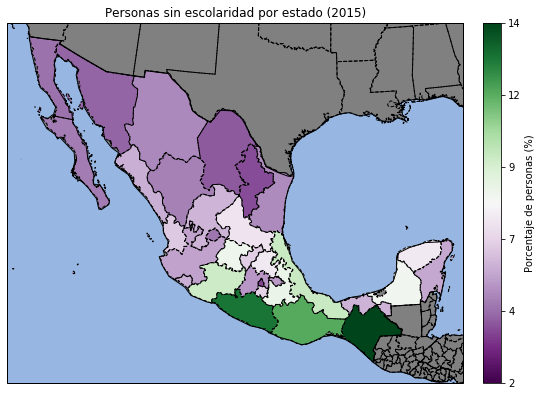

In [400]:
mexico("2015", "Sin escolaridad", "Personas sin escolaridad por estado (2015)", False)

### ¿Existe relación entre la ubicación geografica y el porcentaje de personas que solo tienen educación básica?

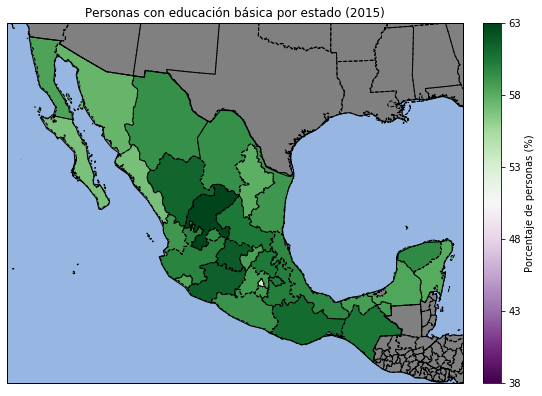

In [401]:
mexico("2015", "Educación básica", "Personas con educación básica por estado (2015)", False)

### ¿Existe relación entre la ubicación geografica y el porcentaje de personas con educación media superior?

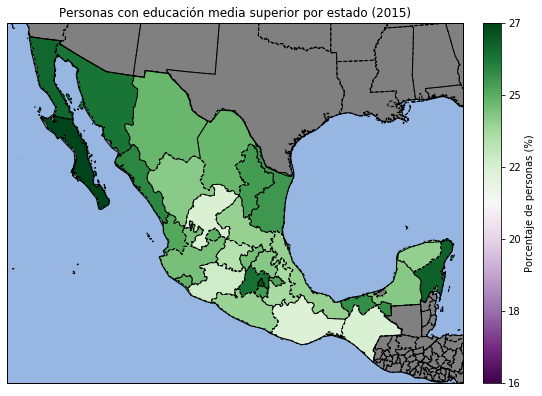

In [402]:
mexico("2015", "Educación media superior", "Personas con educación media superior por estado (2015)", False)

### ¿Existe relación entre la ubicación geografica y el porcentaje de personas con educación superior?

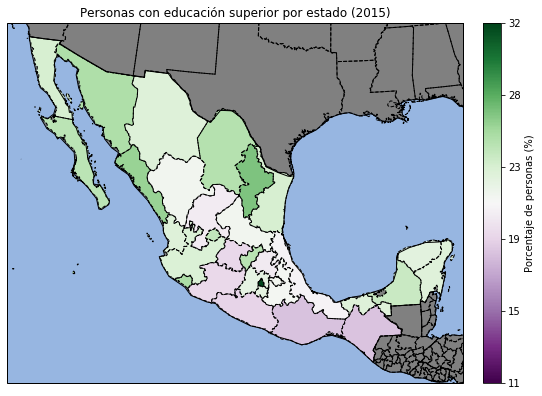

In [403]:
mexico("2015", "Educación superior", "Personas con educación superior por estado (2015)", False)

### ¿Hay diferencia entre el porcentaje de hombres y mujeres sin escolaridad en cada estado?

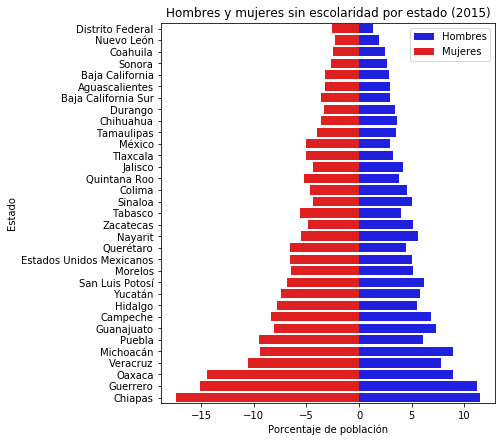

In [404]:
escola = "Sin escolaridad"
año = "2015"
titulo = "Personas sin escolaridad por estado (2015)"
piramide = datos[datos.Escolaridad == escola].sort_values(by = año)
piramide_pro(año, piramide, "Hombres y mujeres sin escolaridad por estado (2015)", False)

### ¿Hay diferencia entre el porcentaje de hombres y mujeres solo con eduación básica en cada estado?

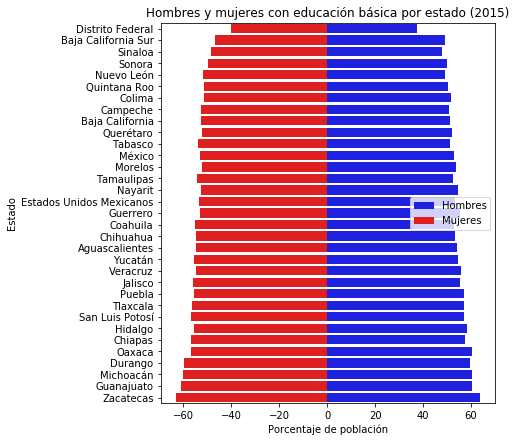

In [405]:
escola = "Educación básica"
año = "2015"
titulo = "Personas sin escolaridad por estado (2015)"
piramide = datos[datos.Escolaridad == escola].sort_values(by = año)
piramide_pro(año, piramide, "Hombres y mujeres con educación básica por estado (2015)", False)

### ¿Hay diferencia entre el porcentaje de hombres y mujeres con educación media superior en cada estado?

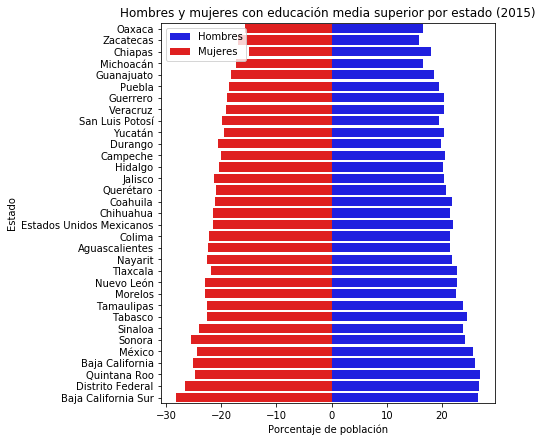

In [406]:
escola = "Educación media superior"
año = "2015"
titulo = "Personas sin escolaridad por estado (2015)"
piramide = datos[datos.Escolaridad == escola].sort_values(by = año)
piramide_pro(año, piramide, "Hombres y mujeres con educación media superior por estado (2015)", False)

### ¿Hay diferencia entre el porcentaje de hombres y mujeres con educación superior en cada estado?

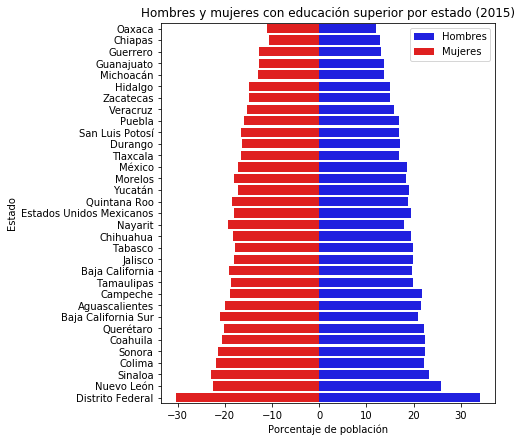

In [407]:
escola = "Educación superior"
año = "2015"
titulo = "Personas sin escolaridad por estado (2015)"
piramide = datos[datos.Escolaridad == escola].sort_values(by = año)
piramide_pro(año, piramide, "Hombres y mujeres con educación superior por estado (2015)", False)

### ¿Cuantas personas hay en cada nivel de escolaridad en México?

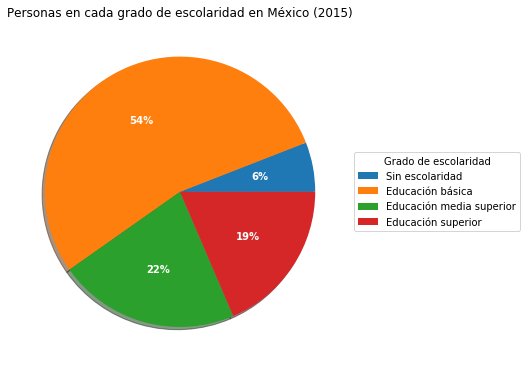

In [408]:
pastel("2015", False)

### ¿Cuantas personas había en cada nivel de escolaridad en el año 2000?

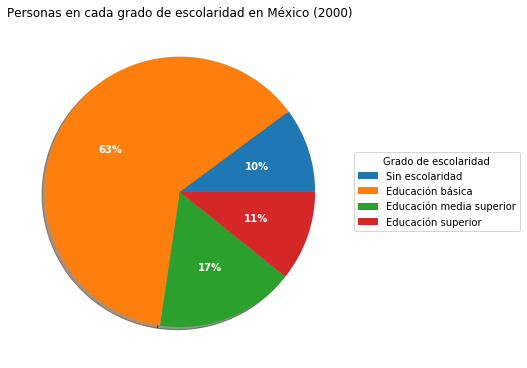

In [409]:
pastel("2000", False)

In [410]:
total = 119530753
escolaridad = []
values = np.zeros((4, 4))
for i in range(4):
    escolaridad.append({
        "Sin escolaridad":0,
        "Educación básica":0,
        "Educación media superior":0,
        "Educación superior":0
    })

count_a=0
for a in range(4):
    count_b=0
    for i in escolaridad[a]:
        for j in datos[datos.Escolaridad == i].Entidad:
            if j != "Estados Unidos Mexicanos":
                escolaridad[a][i]+=int(float(datos[datos.Escolaridad == i][datos.Entidad == j][str(2000+a*5)]/100)*
                                 float(poblacion[poblacion["Entidad federativa"] == j]["Población total"]))
        escolaridad[a][i] = escolaridad[a][i]/total*100
        values[count_a][count_b] = escolaridad[a][i]
        count_b+=1
    count_a+=1

### ¿Cuál ha sido el cambio de escolaridad en México a lo largo del tiempo?

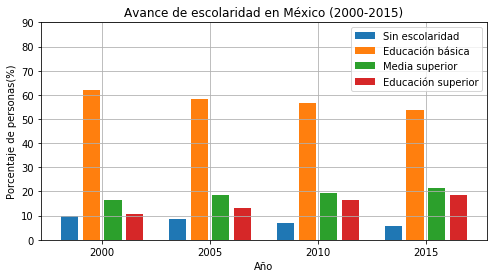

In [411]:
x1 = [1998.5, 2003.5, 2008.5, 2013.5]
x2 = [i+1 for i in x1]
x3 = [i+2 for i in x1]
x4 = [i+3 for i in x1]

fig, ax = plt.subplots(figsize=(8,4))

ax.bar(x1, values.T[0], label = "Sin escolaridad")
ax.bar(x2, values.T[1], label = "Educación básica")
ax.bar(x3, values.T[2], label = "Media superior")
ax.bar(x4, values.T[3], label = "Educación superior")

ax.set_ylabel("Porcentaje de personas(%)")
ax.set_xlabel("Año")
ax.set_xticks([2000, 2005, 2010, 2015])
ax.set_ylim(0, 90)

plt.title("Avance de escolaridad en México (2000-2015)")
plt.legend()
plt.grid()
plt.show()